### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats
from google.cloud import bigquery
from google.oauth2 import service_account
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')

In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

### Import Tuya Data from BQ

In [3]:
# credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
# project_id = 'solar-222307'
# client = bigquery.Client(credentials= credentials,project=project_id)

# query_job = client.query("""
# select * from dev_loggers.tuya 
# """)
# data = query_job.result().to_dataframe() 
# os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Data')
# data.to_csv('Tuya_Device_Data.csv')

### Import Tuya Data from Local

In [4]:
os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Data')
data=pd.read_csv('Tuya_Device_Data.csv')

### Preprocess Data

In [5]:
data['value']=data['value'].replace('true','1').replace('false','0')
data['value']=data['value'].astype(float)
data['event_time_utc']=pd.to_datetime(data['event_time_utc'])
data=data.drop_duplicates(subset=['device_id','event_timestamp','code','value'])
data

,Unnamed: 0,property_id,device_id,code,event_from,event_id,event_timestamp,event_time_utc,status,value
0,0,15,bf425667df5e89d62fhjvu,cur_power,1,7,1604096669571,2020-10-30 22:24:29.571,1,194.0
1,1,15,bf425667df5e89d62fhjvu,cur_power,1,7,1604093068766,2020-10-30 21:24:28.766,1,195.0
2,2,15,bf425667df5e89d62fhjvu,cur_power,1,7,1604089813135,2020-10-30 20:30:13.135,1,195.0
3,3,15,bf425667df5e89d62fhjvu,cur_power,1,7,1604100742299,2020-10-30 23:32:22.299,1,188.0
4,4,15,bf425667df5e89d62fhjvu,cur_power,1,7,1604099734278,2020-10-30 23:15:34.278,1,183.0
...,...,...,...,...,...,...,...,...,...,...
110097,110097,20,bfcb5ddd31910b7db0cata,cur_current,1,7,1604687513760,2020-11-06 18:31:53.760,1,19.0
110098,110098,20,bfcb5ddd31910b7db0cata,cur_power,1,7,1604686700653,2020-11-06 18:18:20.653,1,1413.0
110099,110099,20,bfcb5ddd31910b7db0cata,cur_power,1,7,1604687543937,2020-11-06 18:32:23.937,1,0.0
110100,110100,20,bfcb5ddd31910b7db0cata,cur_current,1,7,1604687543937,2020-11-06 18:32:23.937,1,0.0


### Make Pivot Table

In [8]:
pivot_data=data.pivot_table(index=['property_id','device_id','event_time_utc'], columns='code', values='value')
pivot_data=pivot_data.reset_index()
pivot_data['Date']=[i.date() for i in pivot_data['event_time_utc']]

# for i in range(1,len(pivot_data)):
#     if np.isnan(pivot_data['cur_voltage'][i]) and np.isnan(pivot_data['switch_1'][i]):
#         pivot_data.loc[i,'cur_voltage']=pivot_data['cur_voltage'].iloc[i-1]

for i,j in pivot_data[['device_id','property_id']].drop_duplicates().itertuples(index=False):
    pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_voltage']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_voltage'].fillna(method='ffill')
    pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_power']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_power'].fillna(method='ffill')
    pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_current']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_current'].fillna(method='ffill')
    
    
pivot_data['Month'] = [i.month for i in pivot_data['event_time_utc']]
pivot_data['Week'] = [i.week for i in pivot_data['event_time_utc']]
pivot_data['Year'] = [i.year for i in pivot_data['event_time_utc']]

pivot_data.head(50)

code,property_id,device_id,event_time_utc,countdown_1,cur_current,cur_power,cur_voltage,switch_1,Date,Month,Week,Year
0,15,bf425667df5e89d62fhjvu,2020-08-25 16:52:54.698,NaN,NaN,NaN,NaN,1.0,2020-08-25,8,35,2020
1,15,bf425667df5e89d62fhjvu,2020-08-25 16:53:07.707,NaN,77.0,159.0,2443.0,NaN,2020-08-25,8,35,2020
2,15,bf425667df5e89d62fhjvu,2020-08-25 16:53:09.709,NaN,112.0,168.0,2443.0,NaN,2020-08-25,8,35,2020
3,15,bf425667df5e89d62fhjvu,2020-08-25 16:53:39.711,NaN,74.0,154.0,2434.0,NaN,2020-08-25,8,35,2020
4,15,bf425667df5e89d62fhjvu,2020-08-25 16:56:00.715,NaN,82.0,154.0,2386.0,NaN,2020-08-25,8,35,2020
5,15,bf425667df5e89d62fhjvu,2020-08-25 16:57:01.717,NaN,91.0,159.0,2412.0,NaN,2020-08-25,8,35,2020
6,15,bf425667df5e89d62fhjvu,2020-08-25 16:58:04.719,NaN,80.0,155.0,2412.0,NaN,2020-08-25,8,35,2020
7,15,bf425667df5e89d62fhjvu,2020-08-25 17:00:29.722,NaN,89.0,156.0,2408.0,NaN,2020-08-25,8,35,2020
8,15,bf425667df5e89d62fhjvu,2020-08-25 17:04:00.726,NaN,79.0,155.0,2408.0,NaN,2020-08-25,8,35,2020
9,15,bf425667df5e89d62fhjvu,2020-08-25 17:05:40.730,NaN,71.0,152.0,2412.0,NaN,2020-08-25,8,35,2020


### Function to get aggregated Energy and Time Stats per Property

In [7]:
def Get_Energy_and_Time_Usage(pivotdata , propid):
    device_usage=pd.DataFrame(index=[i.date() for i in pd.date_range(pivotdata['event_time_utc'].min(),pivotdata['event_time_utc'].max(), freq='H')],
                              columns=pivotdata['device_id'].unique())

    device_usage_energy=pd.DataFrame(index=[i.date() for i in pd.date_range(pivotdata['event_time_utc'].min(),pivotdata['event_time_utc'].max(), freq='H')],
                              columns=pivotdata['device_id'].unique())

    state=0
    pivotdata=pivotdata[pivotdata.property_id==propid].sort_values('event_time_utc')
    for device,df in pivotdata.groupby('device_id'):
        state=0
        prev_day_power=0
        for date in device_usage.index:
            temp=df[df['Date']==date][['event_time_utc','switch_1','cur_power']]
            time=pd.to_datetime(date)
            total_time=0
            total_energy=0
            for i in range(len(temp)):
                if state==1:
                    if temp['switch_1'].iloc[i]==0:
                        state=0
                        total_time=total_time+(temp['event_time_utc'].iloc[i]-pd.to_datetime(time)).seconds
                        time=temp['event_time_utc'].iloc[i]
                    elif temp['switch_1'].iloc[i]==1:
                        total_time=total_time+(temp['event_time_utc'].iloc[i]-pd.to_datetime(time)).seconds
                        time=temp['event_time_utc'].iloc[i]

                if state==0:
                    if temp['switch_1'].iloc[i]==0:
                        time=temp['event_time_utc'].iloc[i]
                    elif temp['switch_1'].iloc[i]==1:
                        state=1
                        time=temp['event_time_utc'].iloc[i]

                if np.isnan(temp['switch_1'].iloc[i]):
                    if (state==1) & (np.isnan(temp['cur_power'].iloc[i])==False):
                        if i==0:
                            total_energy=total_energy+(temp['event_time_utc'].iloc[i]-pd.to_datetime(date)).seconds*prev_day_power+(temp['event_time_utc'].iloc[i+1]-temp['event_time_utc'].iloc[i]).seconds*temp['cur_power'].iloc[i]/3600
                        elif i==len(temp)-1:
                            total_energy=total_energy+(pd.to_datetime(date)+datetime.timedelta(hours=1)-temp['event_time_utc'].iloc[i]).seconds*temp['cur_power'].iloc[i]/3600
                            prev_day_power=temp['cur_power'].iloc[i]
                        else:    
                            total_energy=total_energy+(temp['event_time_utc'].iloc[i+1]-temp['event_time_utc'].iloc[i]).seconds*temp['cur_power'].iloc[i]/3600


            if state == 1:
                total_time=total_time+(pd.to_datetime(date)-time +datetime.timedelta(hours=1)).seconds
            device_usage_energy.loc[date,device]=total_energy
            device_usage.loc[date,device]=total_time


    device_usage['Month'] = [pd.to_datetime(i).month for i in device_usage.index]
    device_usage['Week'] = [pd.to_datetime(i).week for i in device_usage.index]
    device_usage['Year'] = [pd.to_datetime(i).year for i in device_usage.index]
    device_usage['Date'] = [pd.to_datetime(i).date() for i in device_usage.index]
    device_usage_energy['Month'] = [pd.to_datetime(i).month for i in device_usage_energy.index]
    device_usage_energy['Week'] = [pd.to_datetime(i).week for i in device_usage_energy.index]
    device_usage_energy['Year'] = [pd.to_datetime(i).year for i in device_usage_energy.index]
    device_usage_energy['Date'] = [pd.to_datetime(i).date() for i in device_usage_energy.index]
    
    return device_usage_energy,device_usage

In [8]:
#device_usage_energy,device_usage=Get_Energy_and_Time_Usage(pivot_data , 15)
#device_usage_energy.to_csv('Device_usage_energy.csv')
#device_usage.to_csv('device_usage.csv')
device_usage_energy=pd.read_csv('Device_usage_energy.csv')
device_usage=pd.read_csv('Device_usage.csv')

device_usage_energy.columns.values[0] = "event_time_utc"
device_usage.columns.values[0] = "event_time_utc"
device_usage['event_time_utc']=pd.to_datetime(device_usage['event_time_utc'])
device_usage_energy['event_time_utc']=pd.to_datetime(device_usage_energy['event_time_utc'])
device_usage['Date']=pd.to_datetime(device_usage['Date'])
device_usage_energy['Date']=pd.to_datetime(device_usage_energy['Date'])

### Obtain Energy Statistics

In [9]:
pivot_data=pivot_data.set_index('event_time_utc').sort_index()
pivot_data['cur_energy']=0
pivot_data['time_used']=0
for device,df in pivot_data.groupby('device_id'):
    df=df[['cur_power','cur_energy','switch_1']].groupby(level=0).max()
    df.cur_power=df.cur_power.fillna(0)
    state=0
    for i,j in zip(df.index[:-1],df.index[1:]):
        if i!=j:
            if (np.isnan(df.loc[i,'switch_1'])==True) and (state==1):
                pivot_data.loc[(pivot_data['device_id']==device) & (pivot_data.index==i),'cur_energy']=(j-i).seconds/3600*df.loc[i,'cur_power']
                pivot_data.loc[(pivot_data['device_id']==device) & (pivot_data.index==i),'time_used']=(j-i).seconds/3600
            else:
                state=df.loc[i,'switch_1']

pivot_data['cumulative_energy']=0
for i,j in pivot_data[['device_id','property_id']].drop_duplicates().itertuples(index=False):
    pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cumulative_energy']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cur_energy'].cumsum()

pivot_data['cumulative_time']=0
for i,j in pivot_data[['device_id','property_id']].drop_duplicates().itertuples(index=False):
    pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'cumulative_time']=pivot_data.loc[(pivot_data.device_id==i) & (pivot_data.property_id==j), 'time_used'].cumsum()

lis=[]
for i in pivot_data.index:
    if i.hour<=6:
        lis.append('Night')
    elif i.hour<=12:
        lis.append('Morning')
    elif i.hour<=18:
        lis.append('Afternoon')
    else:
        lis.append('Evening')
        
pivot_data['time_of_day']=lis
# pivot_data.to_csv('Pivot_Data_Energy.csv')    

KeyboardInterrupt: 

### Or Read From Local

In [10]:
pivot_data=pd.read_csv('Pivot_Data_Energy.csv')
pivot_data['event_time_utc']=pd.to_datetime(pivot_data['event_time_utc'])

In [11]:
#from scipy.ndimage.filters import gaussian_filter1d

#x=plot_df[((plot_df.mean()-3*plot_df.std())<plot_df) & (plot_df<(plot_df.mean()+3*plot_df.std()))].resample('5min').sum().fillna(0)
#x=x[:288]

#xnew = np.linspace(0, len(x), len(x))

#spl2 = gaussian_filter1d(x, sigma=2)
#y_mod=get_natural_cubic_spline_model(xnew, x, minval=min(xnew), maxval=max(xnew), n_knots=30)
#xnew2 = np.linspace(0, len(x)+10, len(x)+10)
#spl=y_mod.predict(xnew)
#plt.plot(xnew, spl)
#plt.fill_between(xnew,spl)
#plt.show()

#plt.plot(xnew, spl2)
#plt.fill_between(xnew,spl2)
#plt.show()



### Import Energy Usage Data (5min Interval) from BQ

In [12]:
# os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Config')
# credentials = service_account.Credentials.from_service_account_file('bigqueryauth.json')
# project_id = 'solar-222307'
# client = bigquery.Client(credentials= credentials,project=project_id)

# query_job = client.query("""
# select * from dashboard.production
# where property_id=1737
# """)

# energy_data= query_job.result().to_dataframe() 
# os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Data')
# energy_data.to_csv('Dashboard_Energy_Usage.csv') 

### Import Energy Usage Data (5min Interval) from Local

In [ ]:
os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Vizualisations\Data')
energy_data=pd.read_csv('Dashboard_Energy_Usage.csv')
energy_data

### Preprocess Data

In [ ]:
energy_data['created_on_utc']=pd.to_datetime(energy_data['created_on_utc'])
energy_data['logged_time_utc']=pd.to_datetime(energy_data['logged_time_utc'])
energy_data['logged_time_local']=pd.to_datetime(energy_data['logged_time_local'])
energy_data=energy_data.set_index('logged_time_utc').sort_index()
energy_data.tail()

### Function to get property-wise data (tuya + 5min)

In [ ]:
def get_property_device_data_power(prop_id1,prop_id2):
    temp=energy_data[(energy_data['property_id']==prop_id2)][['solar_to_grid_power','solar_to_home_power','grid_to_home_power']].resample('1min').mean()
    for i in pivot_data.loc[(pivot_data['property_id']==prop_id1),'device_id'].unique():
        temp=temp.join(pivot_data[(pivot_data['property_id']==prop_id1) & (pivot_data['device_id']==i)].set_index('event_time_utc')[['cur_power']].resample('1min').mean(),rsuffix='_'+i)
    temp.columns.values[3]=temp.columns.values[3]+'_'+pivot_data.loc[(pivot_data['property_id']==prop_id1),'device_id'].unique()[0]
    return temp
property_data_power=get_property_device_data_power(15,1737)

# property_data_power.to_csv('property_data_power.csv')

In [29]:
property_data_power=pd.read_csv('property_data_power.csv')
property_data_power['logged_time_utc']=pd.to_datetime(property_data_power['logged_time_utc'])
property_data_power=property_data_power.set_index('logged_time_utc')

property_data_power[property_data_power.index>=pd.to_datetime('2020-10-01')].head(50)

,solar_to_grid_power,solar_to_home_power,grid_to_home_power,cur_power_bff9556124920d2b243e9f,cur_power_bf425667df5e89d62fhjvu,cur_power_bfa9489885a2c54078s87z
logged_time_utc,,,,,,
2020-10-01 00:00:00,0.0,0.0,0.46,NaN,NaN,NaN
2020-10-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:05:00,0.0,0.0,0.45,NaN,NaN,NaN
2020-10-01 00:06:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:07:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-01 00:08:00,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def show_property_data_power(start_time, end_time, device_id):
    
    temp=property_data_power[(property_data_power.index<=pd.to_datetime(end_time)+datetime.timedelta(days=1)) & (property_data_power.index>=pd.to_datetime(start_time))]
    fig,ax =plt.subplots()
    fig.set_size_inches(15,5)
    (10000*temp.iloc[:,1:3]).plot.area(ax=ax,stacked=False)
    if device_id=='ALL':
        (temp.iloc[:,3:]).plot.area(ax=ax,stacked=False)
    else:
        (temp['cur_power_'+device_id]).plot.area(ax=ax)
    ax.grid(False)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()
    return temp
#abs

tempdf=show_property_data_power('2020-11-01', '2020-11-01','ALL')

In [18]:
# def get_property_device_data_energy(prop_id1,prop_id2):
#     temp=energy_data[(energy_data['property_id']==prop_id2)][['solar_to_grid_energy','solar_to_home_energy','grid_to_home_energy']].resample('1min').mean()
#     for i in pivot_data.loc[(pivot_data['property_id']==prop_id1),'device_id'].unique():
#         temp=temp.join(pivot_data[(pivot_data['property_id']==prop_id1) & (pivot_data['device_id']==i)].set_index('event_time_utc')[['cumulative_energy']].resample('1min').mean(),rsuffix='_'+i)
#     temp.columns.values[3]=temp.columns.values[3]+'_'+pivot_data.loc[(pivot_data['property_id']==prop_id1),'device_id'].unique()[0]
#     return temp
# property_data=get_property_device_data_energy(15,1737)


# property_data=property_data.fillna(method='ffill')

# property_data.to_csv('property_data_energy.csv')

In [31]:
property_data=pd.read_csv('property_data_energy.csv')
property_data['logged_time_utc']=pd.to_datetime(property_data['logged_time_utc'])
property_data=property_data.set_index('logged_time_utc')

property_data[property_data.index>=pd.to_datetime('2020-10-01')]

,solar_to_grid_energy,solar_to_home_energy,grid_to_home_energy,cumulative_energy_bff9556124920d2b243e9f,cumulative_energy_bf425667df5e89d62fhjvu,cumulative_energy_bfa9489885a2c54078s87z
logged_time_utc,,,,,,
2020-10-01 00:00:00,3924.39,2817.25,5378.66,2.321424e+06,4.192832e+06,0.000000
2020-10-01 00:01:00,3924.39,2817.25,5378.66,2.321424e+06,4.192832e+06,0.000000
2020-10-01 00:02:00,3924.39,2817.25,5378.66,2.321424e+06,4.192832e+06,0.000000
2020-10-01 00:03:00,3924.39,2817.25,5378.66,2.321424e+06,4.192832e+06,0.000000
2020-10-01 00:04:00,3924.39,2817.25,5378.66,2.321424e+06,4.192832e+06,0.000000
...,...,...,...,...,...,...
2020-11-06 19:31:00,4393.29,3089.65,5890.62,4.358818e+06,5.089109e+06,358702.494722
2020-11-06 19:32:00,4393.29,3089.65,5890.62,4.358818e+06,5.089109e+06,358702.494722
2020-11-06 19:33:00,4393.29,3089.65,5890.62,4.358818e+06,5.089109e+06,358702.494722


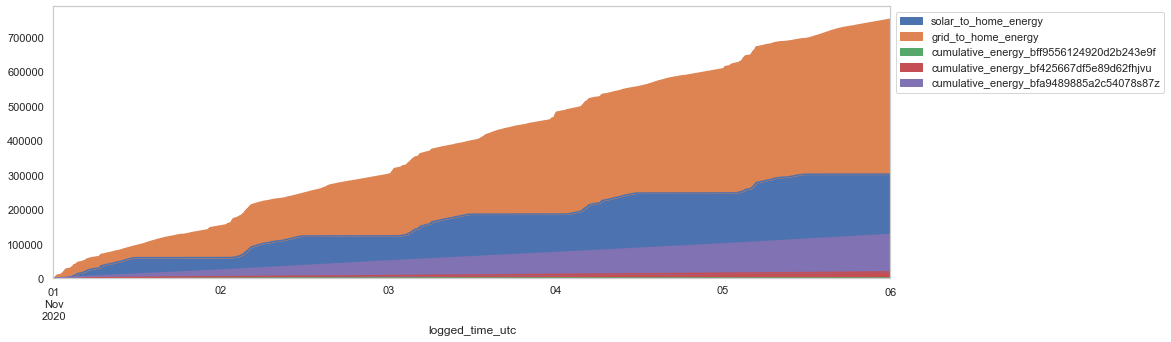

In [20]:
def show_property_data(start_time, end_time, device_id):
    
    temp=property_data[(property_data.index<=pd.to_datetime(end_time)+datetime.timedelta(days=1)) & (property_data.index>=pd.to_datetime(start_time))]
    fig,ax =plt.subplots()
    fig.set_size_inches(15,5)
    (10000*temp.iloc[:,1:3]- 10000*temp.iloc[0,1:3]).plot.area(ax=ax)
    if device_id=='ALL':
        (temp.iloc[:,-3:].resample('1d').interpolate(method='linear')-temp.iloc[0,-3:]).plot.area(ax=ax)
    else:
        (temp['cumulative_energy_'+device_id].resample('1d').interpolate(method='linear')-temp['cumulative_energy_'+device_id].iloc[0]).plot.area(ax=ax)
    ax.grid(False)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()
    return temp
#abs

tempdf=show_property_data('2020-11-01', '2020-11-05','ALL')

In [21]:
stdate='2020-10-01'
enddate='2020-10-10'

def aggregate_property_data(stdate,enddate):

    tempdf=property_data[(property_data.index>=pd.to_datetime(stdate)) & (property_data.index<=pd.to_datetime(enddate))].resample('1d').mean()
    
    df=pd.DataFrame(np.zeros(shape=(len(tempdf),len(tempdf.columns[3:]))))
    df.columns= list(tempdf.columns[3:])
    df=df.set_index(tempdf.index)
    for i in tempdf.columns:
        tempdf[i]=tempdf[i]-tempdf[i].shift(1).fillna(0)
    for i in tempdf.columns[3:]:
        df[i]=100*(tempdf[i]/10000)/(tempdf.iloc[:,1]+tempdf.iloc[:,2])

    df['others']=100-df.sum(axis=1)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),gridspec_kw={'width_ratios': [3, 3]})
    df.plot(kind='bar', stacked=True,ax =axes[0], title = 'Daily Energy Usage/Appliance')
    axes[0].set_ylim(0,100)
    axes[0].get_legend().remove()
    axes[1].suptitle=''
    df.sum().plot(kind='pie', autopct='%.2f', labels=['','','',''],  ax=axes[1], title='Overall Energy Usage/Appliance', fontsize=10, label='')
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1, labels=df.columns)
    fig.tight_layout()

In [22]:
def aggregate_energy_input_output_property(stdate,enddate):
    tempdf=property_data[(property_data.index>=pd.to_datetime(stdate)) & (property_data.index<=pd.to_datetime(enddate))]
    lis=[]
    for i in tempdf.index:
        if i.hour<=6:
            lis.append('Night')
        elif i.hour<=12:
            lis.append('Morning')
        elif i.hour<=18:
            lis.append('Afternoon')
        else:
            lis.append('Evening')
    tempdf['time_of_day']=lis
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
    tempdf.iloc[:,:3].sum().plot(kind='pie',label='',ax=axes[0,0], title='Energy Distribution')
    tempdf.pivot_table(index='time_of_day', values=['solar_to_grid_energy','solar_to_home_energy','grid_to_home_energy'], aggfunc=np.sum)[tempdf.columns[:3]].plot(kind='bar', ax=axes[0,1], title='Time of Day')
    tempdf=tempdf.resample('1d').mean()
    for i in tempdf.iloc[:,:3].columns:
        tempdf[i]=tempdf[i]-tempdf[i].shift(1).fillna(0)
    tempdf.iloc[1:,:3].plot(ax=axes[1,0],kind='bar')
    axes[-1, -1].axis('off')
    axes[1,0].legend(loc='upper center', bbox_to_anchor=(1.6, .45),
                  fancybox=True, shadow=True, ncol=1, labels=tempdf.iloc[1:,:3].columns, prop={'size': 13})
    axes[0,1].get_legend().remove()

### Dashboard for Tuya Analytics

In [32]:
ALL = 'ALL'

def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

#dates = pd.date_range(pivot_data['event_time'].sort_values().iloc[0],pivot_data['event_time'].sort_values().iloc[-1], freq='h')
#options = [(i.strftime('%d %b'), i) for i in dates]

dropdown_feature = widgets.Dropdown(options = ['ALL','cur_current','cur_power', 'cur_voltage', 'cur_energy'],description = 'Feature')
dropdown_deviceid = widgets.Dropdown(options = unique_sorted_values_plus_ALL(pivot_data['device_id']), description='Device')
dropdown_propertyid = widgets.Dropdown(options = unique_sorted_values_plus_ALL(pivot_data['property_id']), description='Property')
dropdown_start_day = widgets.DatePicker(description='Start Date')
dropdown_end_day = widgets.DatePicker(description='End Date')
dropdown_aggregate=widgets.Dropdown(options = ['Day','Week', 'Month','Year','Time of the Day'],description = 'Agg_Level')

output=widgets.Output()
plot_output=widgets.Output()
plot_aggregate_value=widgets.Output()
plot_aggregate_value_power=widgets.Output()
plot_aggregate_time=widgets.Output()
plot_disaggregate=widgets.Output()
overall_energy_flow=widgets.Output()

input_widgets = widgets.HBox([dropdown_propertyid,dropdown_start_day , dropdown_end_day, dropdown_deviceid, dropdown_feature,dropdown_aggregate],
                             layout=widgets.Layout(width='100%',display='inline-flex',flex_flow='row wrap'))
tab = widgets.Tab([output, plot_output,plot_aggregate_value,plot_aggregate_value_power,plot_aggregate_time,plot_disaggregate,overall_energy_flow])
tab.set_title(0, 'Dataset Exploration')
tab.set_title(1, 'Scatter Plot')
tab.set_title(2, 'Aggregate Energy Usage')
tab.set_title(3, 'Aggregate Power Usage')
tab.set_title(4, 'Aggregate Time Usage')
tab.set_title(5, 'Disaggregated View')
tab.set_title(6, 'Overall Energy Flow')

def common_filtering(propertyid,day1, day2, device, feature, aggregate):
    
    output.clear_output()
    plot_output.clear_output()
    plot_aggregate_value.clear_output()
    plot_aggregate_value_power.clear_output()
    plot_aggregate_time.clear_output()
    plot_disaggregate.clear_output()
    overall_energy_flow.clear_output()
    if day1 and day2:

        if (device == ALL) & (day1 == ALL):
            common_filter = pivot_data
        elif (propertyid== ALL):
            common_filter = pivot_data[(pivot_data.event_time_utc >= pd.to_datetime(day1)) & (pivot_data.event_time_utc <= pd.to_datetime(day2)+datetime.timedelta(days=1)) & 
                                      (pivot_data.device_id == device)]
        elif (device == ALL):
            
            common_filter = pivot_data[(pivot_data.event_time_utc >= pd.to_datetime(day1)) & (pivot_data.event_time_utc <= pd.to_datetime(day2)+datetime.timedelta(days=1))
                                      & (pivot_data.property_id==propertyid)]
        elif (day1 == ALL):
            common_filter = pivot_data[(pivot_data.device_id == device) & (pivot_data.property_id==propertyid)]
        else:
            common_filter = pivot_data[(pivot_data.event_time_utc >= pd.to_datetime(day1)) & (pivot_data.event_time_utc <= pd.to_datetime(day2)+datetime.timedelta(days=1)) & 
                                      (pivot_data.device_id == device) & (pivot_data.property_id==propertyid)]

        with output:
            display(common_filter)
        with plot_output:

            fig,ax = plt.subplots()
            fig.set_size_inches(15,5)
            ax2 = ax.twinx()
            
            
            if feature == ALL:
                ax.plot(common_filter['event_time_utc'],common_filter[['cur_current','cur_power', 'cur_voltage']], lw=0, ms=2, marker='o')
            else:
                ax.plot(common_filter['event_time_utc'],common_filter[feature], 'g', lw=1, ms=2, marker='o')
            ax2.plot(common_filter['event_time_utc'],common_filter['countdown_1'], 'b', lw=0, ms=2, marker='o')
            ax2.plot(common_filter['event_time_utc'],common_filter['switch_1'], 'y', lw=0, ms=4, marker='o')

            ax.set_ylabel(feature, color='g')
            ax.set_xlabel('Event Time')
            ax2.set_ylabel('Countdown(blue) and Switch(yellow)', color='b')
            plt.show()
            
        with plot_aggregate_value:
            if device in common_filter['device_id'].unique():
                show_property_data(day1,day2,device)
                plt.show()
            elif device== ALL:
                show_property_data(day1,day2,device)
                plt.show()
            else:
                print('Please choose a Device that belongs to this Property')
                
        with plot_aggregate_value_power:
            if device in common_filter['device_id'].unique():
                show_property_data_power(day1,day2,device)
                plt.show()
            elif device== ALL:
                show_property_data_power(day1,day2,device)
                plt.show()
            else:
                print('Please choose a Device that belongs to this Property')
                
        with plot_aggregate_time:
            aggregate=aggregate.replace('Time of the Day','time_of_day').replace('Day','Date')
            fig,ax = plt.subplots()
            fig.set_size_inches(15,5)
            common_filter[(common_filter['event_time_utc']>=pd.to_datetime(day1)) & (common_filter['event_time_utc']<=pd.to_datetime(day2)+datetime.timedelta(days=1))].pivot_table(index=aggregate, values='time_used' , aggfunc=np.sum).plot(kind='bar',ax=ax)
            plt.show()
            
        with plot_disaggregate:
            aggregate_property_data(day1,day2)
            plt.show()
            
        with overall_energy_flow:
            aggregate_energy_input_output_property(day1,day2)
            plt.show()

    else: 
        with output:
            print('Select Start and End Date')

def dropdown_propertyid_eventhandler(change):
    common_filtering(change.new, dropdown_start_day.value,dropdown_end_day.value, dropdown_deviceid.value,
                     dropdown_feature.value,dropdown_aggregate.value)
def dropdown_start_day_eventhandler(change):
    common_filtering(dropdown_propertyid.value, change.new, dropdown_end_day.value, dropdown_deviceid.value,
                     dropdown_feature.value,dropdown_aggregate.value)
def dropdown_end_day_eventhandler(change):
    common_filtering(dropdown_propertyid.value, dropdown_start_day.value, change.new, dropdown_deviceid.value,
                     dropdown_feature.value,dropdown_aggregate.value)
def dropdown_device_eventhandler(change):
    common_filtering(dropdown_propertyid.value, dropdown_start_day.value, dropdown_end_day.value,change.new,
                     dropdown_feature.value,dropdown_aggregate.value)
def dropdown_feature_eventhandler(change):
    common_filtering(dropdown_propertyid.value, dropdown_start_day.value, dropdown_end_day.value, dropdown_deviceid.value, 
                     change.new,dropdown_aggregate.value)
def dropdown_aggregate_eventhandler(change):
    common_filtering(dropdown_propertyid.value, dropdown_start_day.value, dropdown_end_day.value, dropdown_deviceid.value, 
                     dropdown_feature.value,change.new)

dropdown_propertyid.observe(dropdown_propertyid_eventhandler, names='value')
dropdown_deviceid.observe(dropdown_device_eventhandler, names='value')
dropdown_start_day.observe(dropdown_start_day_eventhandler, names='value')
dropdown_end_day.observe(dropdown_end_day_eventhandler, names='value')
dropdown_feature.observe(dropdown_feature_eventhandler, names='value')
dropdown_aggregate.observe(dropdown_aggregate_eventhandler, names='value')

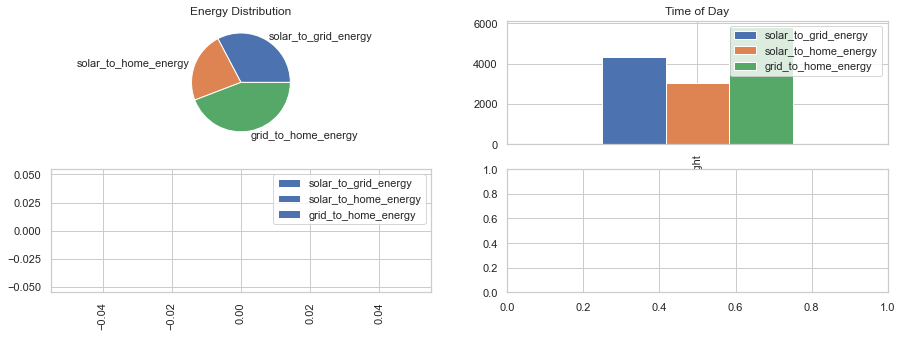

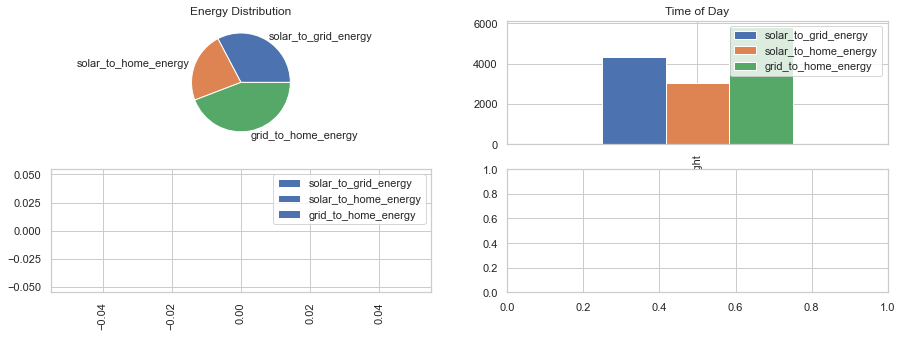

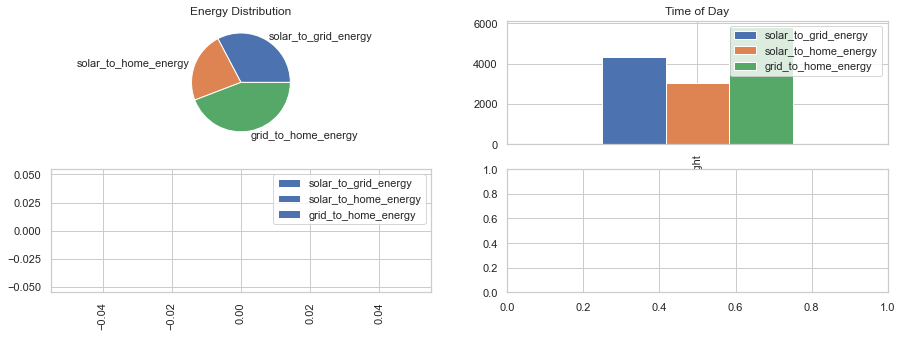

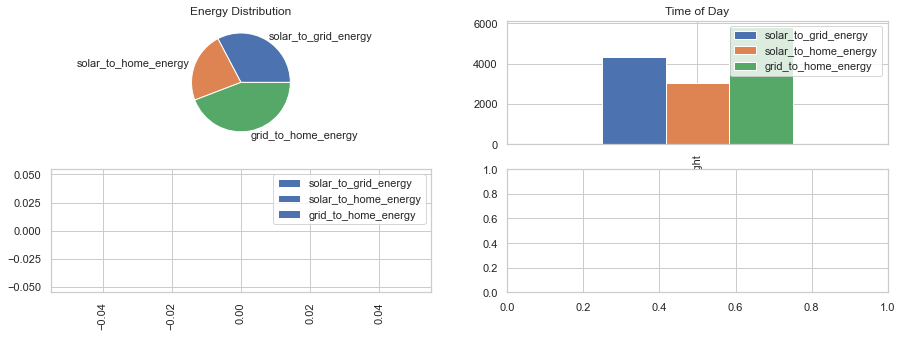

In [33]:
display(input_widgets)
display(tab)

### SANDBOX

In [25]:
df=pivot_data[pivot_data['device_id']==device]
df
pivot_data.loc[pivot_data['device_id']=='bf425667df5e89d62fhjvu']
device='bf425667df5e89d62fhjvu'

NameError: name 'device' is not defined

In [ ]:
pivot_data[(pivot_data['device_id']=='bf425667df5e89d62fhjvu') &  (pivot_data['switch_1']==0)]
pivot_data[(pivot_data.index>='2020-10-23 08:24:31.933') & (pivot_data.property_id==15) & (pivot_data['device_id']=='bf425667df5e89d62fhjvu')].sort_index().head(50)

In [ ]:
pivot_data[(pivot_data['device_id']=='bf425667df5e89d62fhjvu') & (pivot_data['property_id']==15)].set_index('event_time_utc').resample('1min').mean().join(energy_data[energy_data['property_id']==1737][['solar_to_grid_energy','solar_to_home_energy','grid_to_home_energy']])

In [ ]:
property_data

In [ ]:
aggregate_property_data(stdate,enddate)

In [ ]:
## fig,ax = plt.subplots()
fig.set_size_inches(15,5)
pivot_data[(pivot_data['event_time_utc']>=pd.to_datetime('2020-10-01')) & (pivot_data['event_time_utc']<=pd.to_datetime('2020-10-03'))].pivot_table(index='time_of_day', values='time_used' , aggfunc=np.sum).plot(kind='bar',ax=ax)
plt.show()

In [ ]:
pivot_data

In [ ]:
tempdf=property_data[(property_data.index>=pd.to_datetime(stdate)) & (property_data.index<=pd.to_datetime(enddate))]
tempdf
lis=[]
for i in tempdf.index:
    if i.hour<=6:
        lis.append('Night')
    elif i.hour<=12:
        lis.append('Morning')
    elif i.hour<=18:
        lis.append('Afternoon')
    else:
        lis.append('Evening')
tempdf['time_of_day']=lis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
# tempdf.iloc[:,:3].sum().plot(kind='pie',label='',ax=axes[0,0], title='Energy Distribution')
# tempdf.pivot_table(index='time_of_day', values=['solar_to_grid_energy','solar_to_home_energy','grid_to_home_energy'], aggfunc=np.sum)[tempdf.columns[:3]].plot(kind='bar', ax=axes[0,1], title='Time of Day')
# tempdf=tempdf.resample('1d').mean()

tempdf.pivot_table(index='time_of_day', values=['solar_to_grid_energy','solar_to_home_energy','grid_to_home_energy'], aggfunc=np.sum)

In [ ]:
pivot_data['device_id'].unique()